In [1]:
import pandas as pd; pd.set_option('display.max_columns', None)
import numpy as np
import random
import matplotlib.pyplot as plt
from pycaret.classification import *

import sys
sys.path.append('../../../scripts/')
from PreparaDataset import *

### Funções

In [2]:
def split_train_test(data, seed = 2023, train_size = 0.625):
    cls = setup(data = data,
            target = TARGET,
            train_size = train_size,
            verbose = False
            )

    xtrain_treino = get_config('X_train')
    ytrain_treino = get_config('y_train')
    xtrain_teste = get_config('X_test')
    ytrain_teste = get_config('y_test')

    real_treino = pd.concat([xtrain_treino, ytrain_treino], axis=1)
    real_teste = pd.concat([xtrain_teste, ytrain_teste],  axis=1)

    return real_treino, real_teste

# Parâmetros do método

In [3]:
TARGET = 'Back_Home'
ODDS = 'Odds_H'

# Carregando o dataset

In [4]:
data = pd.read_csv('../../../data/entire_season.csv')
data = prepara_df(data)

In [5]:
def prepara_dataset(_df):
    # Limpa _df
    _df.replace([np.inf, -np.inf], 0, inplace=True)
    # _df.dropna(subset=['Avg_CG_H', 'Avg_CG_A', TARGET], inplace=True)

    _df.reset_index(drop=True, inplace=True)

    return _df

In [6]:
df = prepara_dataset(data)

In [7]:
treino, val = split_train_test(df, seed=387)

print(f'Treino: {treino.shape[0]} | Validação: {val.shape[0]}')
print(f"Odd média: {treino[ODDS].mean():.2f}")
print(f"WR: {treino[TARGET].mean():.2f} (Odd justa: {1 / treino[TARGET].mean():.2f})")

Treino: 4237 | Validação: 2543
Odd média: 2.05
WR: 0.57 (Odd justa: 1.76)


# Validação 2

In [ ]:
VAL2_SIZE = 0.5

div = int(VAL2_SIZE * len(val))
val1 = val.iloc[:div, :]
val2 = val.iloc[div: , :]

print(f'Validação 1: {val1.shape[0]} | Validação 2: {val2.shape[0]}')

# Criação do modelo

In [8]:
features = ['Odds_H', 'Odds_A', 'Over_Line', 'Odds_Over', 'Odds_Under', 'HA_Line',
       'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 'Porc_Over_Home',
       'Porc_Over_Away', 'Avg_CG_H', 'DP_CG_H',
       'CV_CG_H', 'Avg_CG_A', 'DP_CG_A', 'CV_CG_A', 'MediaCustoGolHome',
       'MediaCustoGolAway', 'Last_CG_H', 'Last_CG_A', 'Acima_Last_CG_H',
       'Acima_Last_CG_A', 'Abaixo_Last_CG_H', 'Abaixo_Last_CG_A', 'CV_ML',
       'CV_Over', 'CV_HA', 'Retornos_BH_Acu', 'Avg_Retornos_BH', 'Custo_Retorno_BH',
       'Avg_Porc_BH_Bookie', 'Avg_Porc_BH_Real', 'Dist_Porc_BH',
       'Retornos_BA_Acu', 'Avg_Retornos_BA', 'Custo_Retorno_BA',
       'Avg_Porc_BA_Bookie', 'Avg_Porc_BA_Real', 'Dist_Porc_BA', ODDS]

features = ['Odds_H', 'Odds_A', 'Odds_Over', 'Odds_Under', 'Over_Line',  'HA_Line', 'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 
       'P(O)', 'P(U)', 'P_Diff', 'CV_ML',
       'CV_Over', 'CV_HA', 'Last_CG_H', 'Last_CG_A', ODDS]

In [9]:
def cria_setup(seed = 2023, features = features):
    cls = setup(data = treino,
        ignore_features = [x for x in treino.columns.to_list() if x not in features and x != TARGET],
        target = TARGET,
        train_size = 0.5,
        normalize = True,
        normalize_method = 'minmax',
        session_id = seed,
        remove_outliers = True,
        fix_imbalance = True,
        verbose = False
        )

In [10]:
cria_setup(seed = 23, features = features)

xtrain_treino = get_config('X_train')
ytrain_treino = get_config('y_train')
xtrain_teste = get_config('X_test')
ytrain_teste = get_config('y_test')

real_treino = pd.concat([xtrain_treino, ytrain_treino], axis=1)
real_teste = pd.concat([xtrain_teste, ytrain_teste],  axis=1)

In [12]:
top = compare_models(exclude=['catboost', 'dummy'], fold = 5, sort='precision', n_select=14)

,,
,,
Initiated,. . . . . . . . . . . . . . . . . .,15:58:29
Status,. . . . . . . . . . . . . . . . . .,Fitting 5 Folds
Estimator,. . . . . . . . . . . . . . . . . .,Logistic Regression


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
qda,Quadratic Discriminant Analysis,0.6185,0.6971,0.5652,0.7195,0.6162,0.2463,0.2648,0.0580
nb,Naive Bayes,0.6445,0.7156,0.6251,0.7137,0.6660,0.2895,0.2927,0.0580
lr,Logistic Regression,0.6610,0.7311,0.6800,0.7108,0.6948,0.3140,0.3146,0.0660
ridge,Ridge Classifier,0.6601,0.0000,0.6833,0.7083,0.6954,0.3111,0.3116,0.0540
lda,Linear Discriminant Analysis,0.6535,0.7263,0.6817,0.7002,0.6906,0.2969,0.2973,0.0600
svm,SVM - Linear Kernel,0.6464,0.0000,0.7058,0.6964,0.6856,0.2745,0.2973,0.0600
gbc,Gradient Boosting Classifier,0.6431,0.7092,0.6800,0.6884,0.6839,0.2739,0.2742,0.1540
ada,Ada Boost Classifier,0.6332,0.6887,0.6617,0.6828,0.6720,0.2561,0.2564,0.0900
rf,Random Forest Classifier,0.6322,0.6794,0.6725,0.6775,0.6750,0.2514,0.2515,0.1300
xgboost,Extreme Gradient Boosting,0.6261,0.6671,0.6800,0.6678,0.6737,0.2359,0.2362,0.1140


In [13]:
model = create_model('nb', cross_validation=False, return_train_score=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Test,0.6579,0.7161,0.6359,0.7272,0.6785,0.3164,0.3196
Train,0.6426,0.7164,0.6168,0.7148,0.6622,0.2871,0.2906


In [50]:
# Ranges da variável
ranges_dict['P_Diff']

[Interval(0.054, 0.0932, closed='right')]

In [56]:
def filtra_resultados(_df, filtro = 0):
    _df = _df[_df['prediction_label'] == 1]

    if filtro == 1:
        _df = _df[((_df['P_Diff'] > 0.054) & (_df['P_Diff'] < 0.093))]
    
    return _df

In [15]:
def calcula_profit(_df, stake = 1):
    _df.loc[(_df[TARGET] == 1), 'PL_BF_Predictions'] = (_df[ODDS] - 1) * stake
    _df.loc[(_df[TARGET] == 0), 'PL_BF_Predictions'] = - stake

    return _df

def exibe_metricas(_df, total, stake = 1, return_metrics = False):
    plb = _df['PL_BF_Predictions'].sum()
    entradas = _df.shape[0]
    wr = round((_df[_df[TARGET] == 1].shape[0] / entradas), 2)
    oddback = (_df[ODDS].mean())
    med_gain = _df[_df[TARGET] == 1]['PL_BF_Predictions'].mean()
    med_loss = _df[_df[TARGET] == 0]['PL_BF_Predictions'].mean()
    roi = plb / entradas
    porc_ent = entradas / total
    ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)

    if return_metrics == False:
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | Prec.: {wr:.2f}')
        print(f'Odd média: {oddback:.2f} ({1/oddback:.2f} WR)')
        print(f'Média Gain: {med_gain:.2f} | Média Loss: {med_loss:.2f}')
        print(f'EM: {ev:.2f}')
        print(f'{entradas} entradas em {total} jogos ({100*porc_ent:.2f}%)')
    else:
        return_metrics == True
        metrics = [plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev]
        return metrics

def exibe_grafico(_df, per_day = False):
    _df.sort_values('Date', inplace=True)
    _df.reset_index(drop=True, inplace=True)
    
    if per_day:
        
        _df['Date'] = pd.to_datetime(_df['Date'])
        _df_per_day = _df.groupby(_df['Date'].dt.date)['PL_BF_Predictions'].sum()
        _df_per_day = _df_per_day.reset_index()
        
        # Criar um novo DataFrame com colunas 'Date' e 'Accumulated'
        new_df = pd.DataFrame({
            'Date': _df_per_day['Date'],
            'PL': _df_per_day['PL_BF_Predictions']
        })

        new_df['hbacu'] = new_df['PL'].cumsum()
        new_df['hbacu'].plot.line(figsize=(7, 2))
        plt.xlabel('Index')
        plt.ylabel('Acumulado')
        plt.title('Acumulado por dia')
        plt.show()

    else:
        _df['hbacu'] = _df['PL_BF_Predictions'].cumsum()
        _df['hbacu'].plot.line(figsize=(7, 2))
        _df.sort_values('Date', inplace=True)
        plt.xlabel('Index')
        plt.ylabel('Acumulado')
        plt.title('Acumulado por jogo')
        plt.show()

def treina_modelo(modelo, data):
    _df = predict_model(modelo, data, verbose = False)
    _df = _df.merge(df[[TARGET, 'Date']], left_index=True, right_index=True, how='left')
    if f'{TARGET}_x' in _df.columns.tolist():
        _df.rename(columns={f'{TARGET}_x': TARGET}, inplace=True)
        _df.drop(columns=f'{TARGET}_y', inplace=True)
    if 'Date_x' in _df.columns.tolist():
        _df.rename(columns={'Date_x': 'Date'}, inplace=True)
        _df.drop(columns='Date_y', inplace=True)
    
    return _df

def info_modelo(modelo, data, stake = 1, filtro = 0, per_day = False):
    total = data.shape[0]

    _df = treina_modelo(modelo, data)
    _df = filtra_resultados(_df, filtro=filtro)
    _df = calcula_profit(_df, stake)
    exibe_metricas(_df, total, stake)
    exibe_grafico(_df, per_day)
    
    return _df


PL: 11.66 | ROI: 4.98% | Prec.: 0.71
Odd média: 1.57 (0.64 WR)
Média Gain: 0.47 | Média Loss: -1.00
EM: 0.04
234 entradas em 2118 jogos (11.05%)


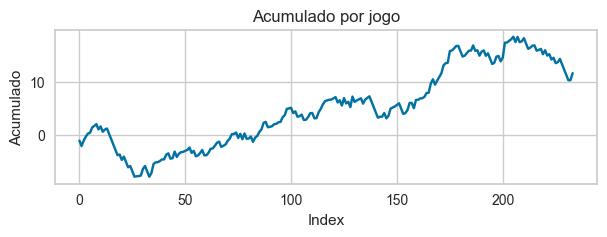

PL: 1.02 | ROI: 0.49% | Prec.: 0.69
Odd média: 1.54 (0.65 WR)
Média Gain: 0.46 | Média Loss: -1.00
EM: 0.01
209 entradas em 2119 jogos (9.86%)


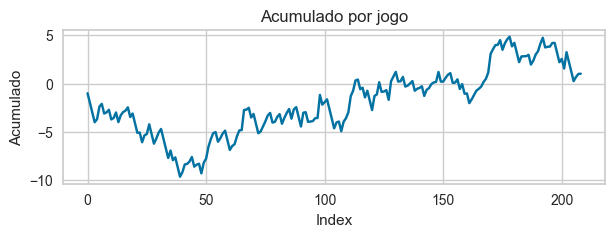

PL: 12.68 | ROI: 2.86% | Prec.: 0.70
Odd média: 1.56 (0.64 WR)
Média Gain: 0.47 | Média Loss: -1.00
EM: 0.03
443 entradas em 4237 jogos (10.46%)


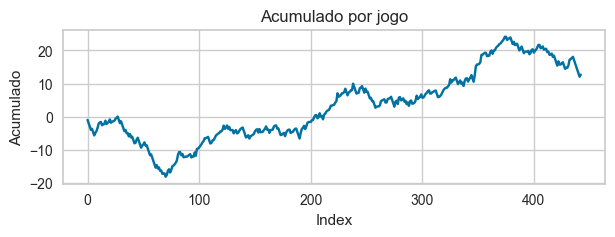

In [57]:
mdl = model
flt = 1
df_treino = info_modelo(mdl, real_treino, filtro = flt, per_day=False)
df_teste = info_modelo(mdl, real_teste, filtro = flt, per_day=False)
df_comp = info_modelo(mdl, treino, filtro = flt, per_day=False)

PL: -7.83 | ROI: -2.67% | Prec.: 0.67
Odd média: 1.58 (0.63 WR)
Média Gain: 0.46 | Média Loss: -1.00
EM: -0.02
293 entradas em 2543 jogos (11.52%)


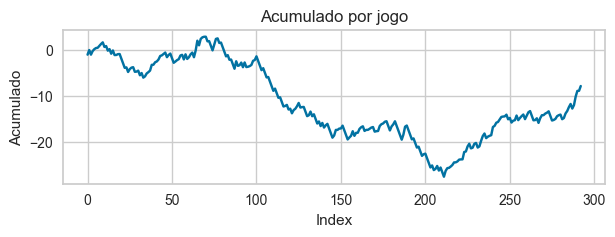

In [58]:
df_val = info_modelo(mdl, val, filtro = flt, per_day=False)

In [ ]:
plt.axvline(x=len(df_teste), color='red', linestyle='--')
entire = pd.concat([df_teste, df_val])
entire.reset_index(drop=True, inplace=True)
entire['acu'] = entire['PL_BF_Predictions'].cumsum()
entire['acu'].plot.line(figsize=(7, 2))

# QCut automático

In [19]:
def find_pos_range(var, treino, teste, validacao, ratio = 0.03, return_train = True, return_val = False):
    nome = f'Cat_{var}'

    # Usa qcut para definir os grupos
    teste[nome]  = pd.qcut(teste[var], q = 5, duplicates='drop')

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(teste,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    ranges = pivot_table[pivot_table['ratio'] > ratio].index.tolist()

    # Máscara booleana para filtrar o DataFrame
    mascara_treino = treino[var].apply(lambda x: any(x in range for range in ranges))
    mascara_teste = teste[var].apply(lambda x: any(x in range for range in ranges))
    mascara_val = validacao[var].apply(lambda x: any(x in range for range in ranges))
        
    # Aplicar a máscara para obter o DataFrame filtrado
    teste_filtrado = teste[mascara_teste]
    treino_filtrado = treino[mascara_treino]
    val_filtrado = validacao[mascara_val]

    print(f'{var}\n')
    if return_train == True:
        print('---------------------  TREINO  ---------------------')
        exibe_metricas(treino_filtrado, total=len(real_treino))
        exibe_grafico(treino_filtrado)
    print('---------------------  TESTE  ---------------------')
    exibe_metricas(teste_filtrado, total=len(real_teste))
    exibe_grafico(teste_filtrado)
    if return_val == True:
        print('---------------------  VALIDAÇÃO  ---------------------')
        exibe_metricas(val_filtrado, total=len(val))
        exibe_grafico(val_filtrado)
    print('\n\n')

    return ranges


def find_top_range(var, treino, teste, validacao, ratio = 3, return_train = True, return_val = False):
    nome = f'Cat_{var}'

    # Usa qcut para definir os grupos
    teste[nome]  = pd.qcut(teste[var], q = 5, duplicates='drop')

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(teste,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )
    

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    pivot_table.sort_values('ratio', ascending=True, inplace=True)
    ranges = pivot_table.index.tolist()

    ranges = ranges[:ratio]

    # Máscara booleana para filtrar o DataFrame
    mascara_treino = treino[var].apply(lambda x: any(x in range for range in ranges))
    mascara_teste = teste[var].apply(lambda x: any(x in range for range in ranges))
    mascara_val = validacao[var].apply(lambda x: any(x in range for range in ranges))
    
    # Aplicar a máscara para obter o DataFrame filtrado
    teste_filtrado = teste[mascara_teste]
    treino_filtrado = treino[mascara_treino]
    val_filtrado = validacao[mascara_val]

    print(f'{var}\n')
    if return_train == True:
        print('---------------------  TREINO  ---------------------')
        exibe_metricas(treino_filtrado, total=len(real_treino))
        exibe_grafico(treino_filtrado)
    print('---------------------  TESTE  ---------------------')
    exibe_metricas(teste_filtrado, total=len(real_teste))
    exibe_grafico(teste_filtrado)
    if return_val == True:
        print('---------------------  VALIDAÇÃO  ---------------------')
        exibe_metricas(val_filtrado, total=len(val))
        exibe_grafico(val_filtrado)
    print('\n\n')

    return ranges


def find_neg_range(var, treino, teste, validacao, return_train = True, return_val = False):
    nome = f'Cat_{var}'

    # Usa qcut para definir os grupos
    teste[nome]  = pd.qcut(teste[var], q = 5, duplicates='drop')

    target = 'PL_BF_Predictions'
    pivot_table = pd.pivot_table(teste,
                                values=target,
                                index=[nome],
                                aggfunc=['sum', 'count']
                                )
    

    pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

    pivot_table.sort_values('ratio', ascending=True, inplace=True)
    ranges = pivot_table.index.tolist()
    
    # Pegar apenas o primeiro intervalo da lista
    range = ranges[0]

    # Criar a máscara booleana para valores dentro do primeiro intervalo
    mascara_treino = treino[var].apply(lambda x: x in range)
    mascara_teste = teste[var].apply(lambda x: x in range)
    mascara_val = validacao[var].apply(lambda x: x in range)

    mascara_treino = ~mascara_treino
    mascara_teste = ~mascara_teste
    mascara_val = ~mascara_val
    
    # Aplicar a máscara para obter o DataFrame filtrado
    treino_filtrado = treino[mascara_treino]
    teste_filtrado = teste[mascara_teste]
    val_filtrado = validacao[mascara_val]

    print(f'{var}\n')
    if return_train == True:
        print('---------------------  TREINO  ---------------------')
        exibe_metricas(treino_filtrado, total=len(real_treino))
        exibe_grafico(treino_filtrado)
    print('---------------------  TESTE  ---------------------')
    exibe_metricas(teste_filtrado, total=len(real_teste))
    exibe_grafico(teste_filtrado)
    if return_val == True:
        print('---------------------  VALIDAÇÃO  ---------------------')
        exibe_metricas(val_filtrado, total=len(val))
        exibe_grafico(val_filtrado)
    print('\n\n')

    return range

In [59]:
autocut_treino = df_treino.copy()
autocut_teste = df_teste.copy()
autocut_val = df_val.copy()

Odds_H

---------------------  TREINO  ---------------------
PL: 9.99 | ROI: 5.20% | Prec.: 0.66
Odd média: 1.67 (0.60 WR)
Média Gain: 0.60 | Média Loss: -1.00
EM: 0.06
192 entradas em 2118 jogos (9.07%)


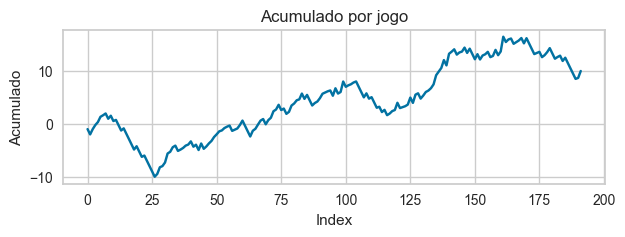

---------------------  TESTE  ---------------------
PL: 6.68 | ROI: 4.02% | Prec.: 0.66
Odd média: 1.67 (0.60 WR)
Média Gain: 0.58 | Média Loss: -1.00
EM: 0.05
166 entradas em 2119 jogos (7.83%)


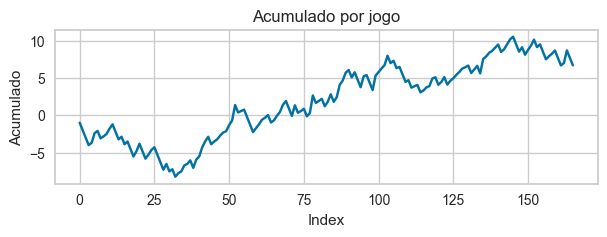




Odds_A

---------------------  TREINO  ---------------------
PL: 10.14 | ROI: 5.25% | Prec.: 0.66
Odd média: 1.67 (0.60 WR)
Média Gain: 0.60 | Média Loss: -1.00
EM: 0.06
193 entradas em 2118 jogos (9.11%)


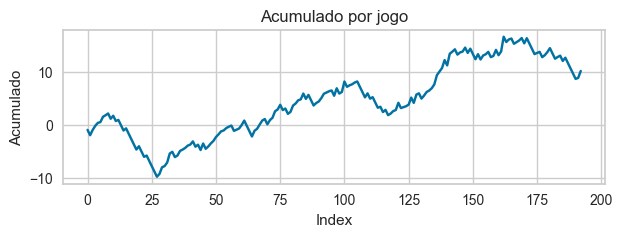

---------------------  TESTE  ---------------------
PL: 7.96 | ROI: 4.77% | Prec.: 0.66
Odd média: 1.66 (0.60 WR)
Média Gain: 0.58 | Média Loss: -1.00
EM: 0.04
167 entradas em 2119 jogos (7.88%)


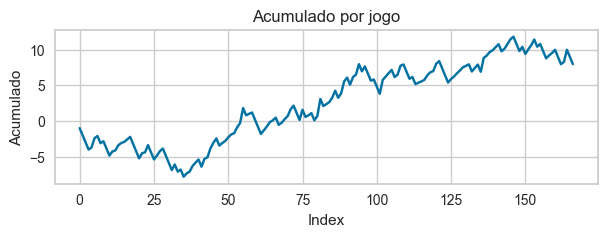




Odds_Over

---------------------  TREINO  ---------------------
PL: 3.09 | ROI: 1.68% | Prec.: 0.70
Odd média: 1.56 (0.64 WR)
Média Gain: 0.46 | Média Loss: -1.00
EM: 0.02
184 entradas em 2118 jogos (8.69%)


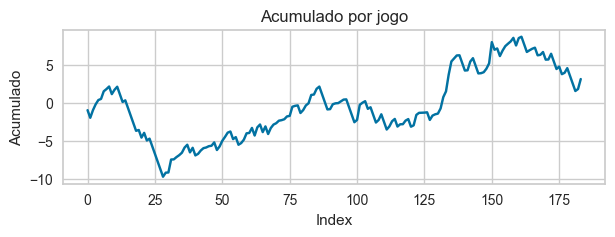

---------------------  TESTE  ---------------------
PL: 0.93 | ROI: 0.53% | Prec.: 0.69
Odd média: 1.55 (0.64 WR)
Média Gain: 0.46 | Média Loss: -1.00
EM: 0.01
174 entradas em 2119 jogos (8.21%)


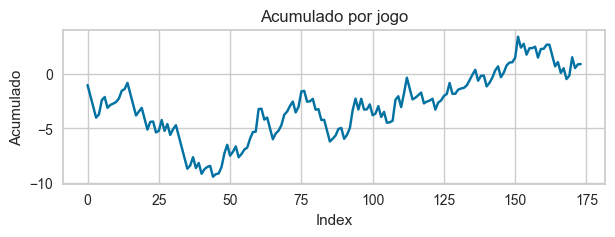




Odds_Under

---------------------  TREINO  ---------------------
PL: 19.50 | ROI: 11.47% | Prec.: 0.75
Odd média: 1.59 (0.63 WR)
Média Gain: 0.49 | Média Loss: -1.00
EM: 0.12
170 entradas em 2118 jogos (8.03%)


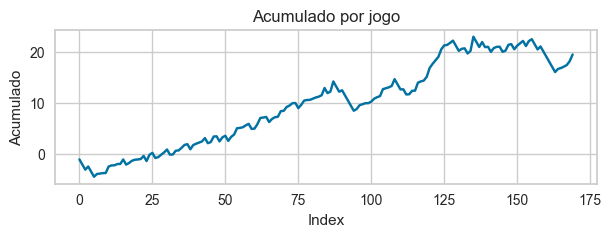

---------------------  TESTE  ---------------------
PL: 5.25 | ROI: 3.65% | Prec.: 0.71
Odd média: 1.55 (0.65 WR)
Média Gain: 0.46 | Média Loss: -1.00
EM: 0.04
144 entradas em 2119 jogos (6.80%)


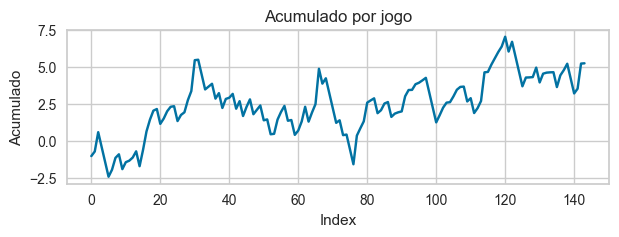




Over_Line

---------------------  TREINO  ---------------------
PL: 8.09 | ROI: 4.60% | Prec.: 0.70
Odd média: 1.57 (0.64 WR)
Média Gain: 0.48 | Média Loss: -1.00
EM: 0.04
176 entradas em 2118 jogos (8.31%)


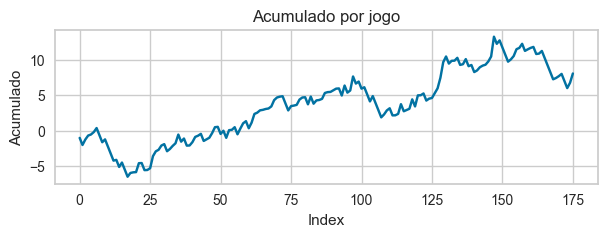

---------------------  TESTE  ---------------------
PL: 5.63 | ROI: 3.35% | Prec.: 0.70
Odd média: 1.57 (0.64 WR)
Média Gain: 0.48 | Média Loss: -1.00
EM: 0.04
168 entradas em 2119 jogos (7.93%)


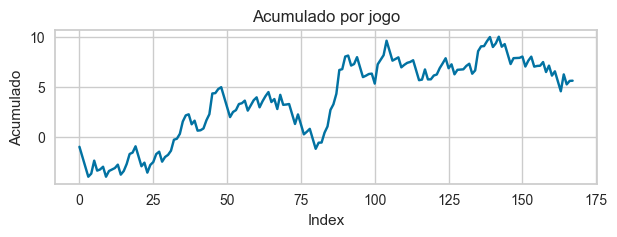




HA_Line

---------------------  TREINO  ---------------------
PL: 12.11 | ROI: 6.80% | Prec.: 0.69
Odd média: 1.67 (0.60 WR)
Média Gain: 0.56 | Média Loss: -1.00
EM: 0.08
178 entradas em 2118 jogos (8.40%)


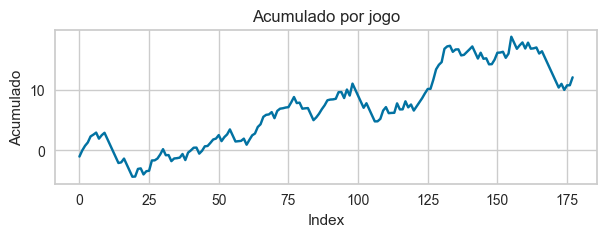

---------------------  TESTE  ---------------------
PL: 7.79 | ROI: 4.90% | Prec.: 0.69
Odd média: 1.64 (0.61 WR)
Média Gain: 0.53 | Média Loss: -1.00
EM: 0.06
159 entradas em 2119 jogos (7.50%)


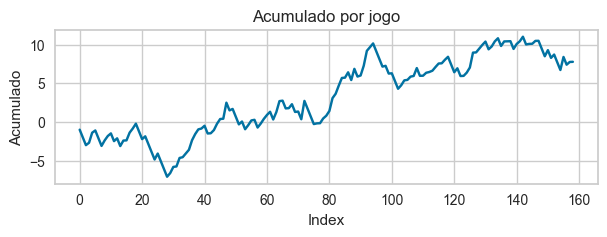




HA_Odds_H

---------------------  TREINO  ---------------------
PL: -0.89 | ROI: -0.53% | Prec.: 0.69
Odd média: 1.55 (0.64 WR)
Média Gain: 0.45 | Média Loss: -1.00
EM: -0.00
169 entradas em 2118 jogos (7.98%)


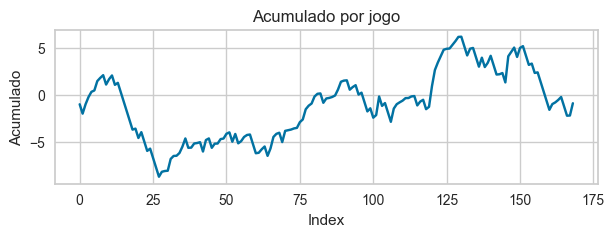

---------------------  TESTE  ---------------------
PL: 3.52 | ROI: 2.27% | Prec.: 0.69
Odd média: 1.58 (0.63 WR)
Média Gain: 0.48 | Média Loss: -1.00
EM: 0.02
155 entradas em 2119 jogos (7.31%)


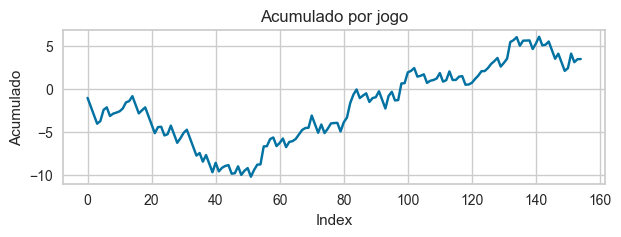




HA_Odds_A

---------------------  TREINO  ---------------------
PL: 22.43 | ROI: 11.62% | Prec.: 0.76
Odd média: 1.57 (0.64 WR)
Média Gain: 0.47 | Média Loss: -1.00
EM: 0.11
193 entradas em 2118 jogos (9.11%)


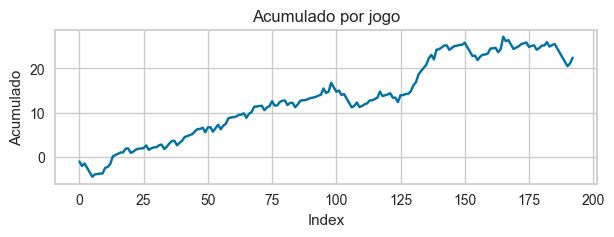

---------------------  TESTE  ---------------------
PL: 8.77 | ROI: 5.73% | Prec.: 0.73
Odd média: 1.55 (0.65 WR)
Média Gain: 0.46 | Média Loss: -1.00
EM: 0.06
153 entradas em 2119 jogos (7.22%)


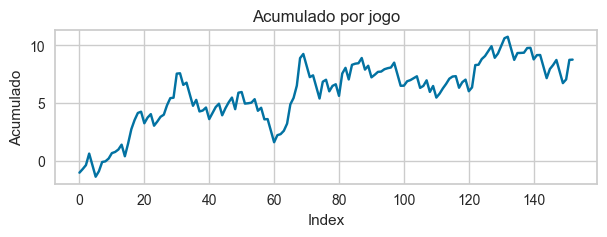




P(H)

---------------------  TREINO  ---------------------
PL: 10.31 | ROI: 5.26% | Prec.: 0.66
Odd média: 1.66 (0.60 WR)
Média Gain: 0.59 | Média Loss: -1.00
EM: 0.05
196 entradas em 2118 jogos (9.25%)


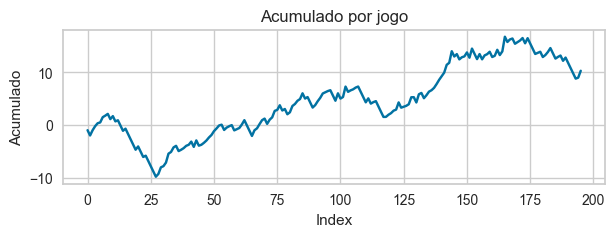

---------------------  TESTE  ---------------------
PL: 7.16 | ROI: 4.16% | Prec.: 0.67
Odd média: 1.65 (0.61 WR)
Média Gain: 0.56 | Média Loss: -1.00
EM: 0.04
172 entradas em 2119 jogos (8.12%)


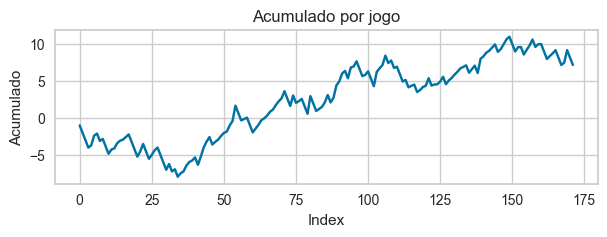




P(A)

---------------------  TREINO  ---------------------
PL: 10.14 | ROI: 5.25% | Prec.: 0.66
Odd média: 1.67 (0.60 WR)
Média Gain: 0.60 | Média Loss: -1.00
EM: 0.06
193 entradas em 2118 jogos (9.11%)


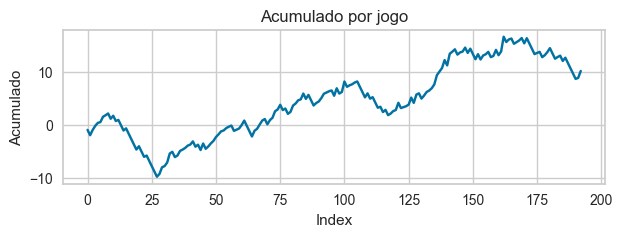

---------------------  TESTE  ---------------------
PL: 7.96 | ROI: 4.77% | Prec.: 0.66
Odd média: 1.66 (0.60 WR)
Média Gain: 0.58 | Média Loss: -1.00
EM: 0.04
167 entradas em 2119 jogos (7.88%)


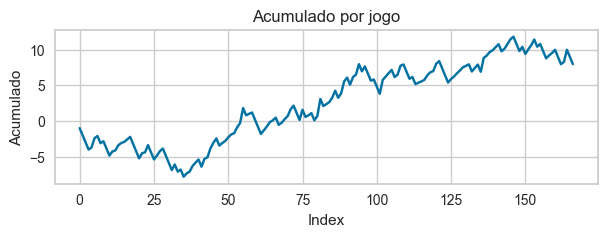




P(O)

---------------------  TREINO  ---------------------
PL: 22.62 | ROI: 13.54% | Prec.: 0.76
Odd média: 1.59 (0.63 WR)
Média Gain: 0.49 | Média Loss: -1.00
EM: 0.13
167 entradas em 2118 jogos (7.88%)


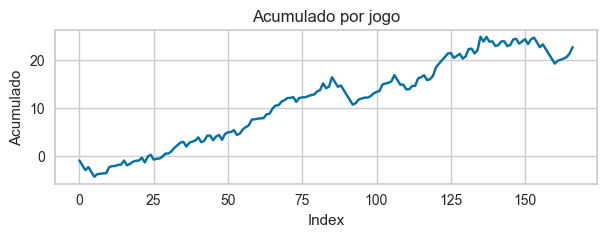

---------------------  TESTE  ---------------------
PL: 3.08 | ROI: 2.10% | Prec.: 0.69
Odd média: 1.54 (0.65 WR)
Média Gain: 0.47 | Média Loss: -1.00
EM: 0.02
147 entradas em 2119 jogos (6.94%)


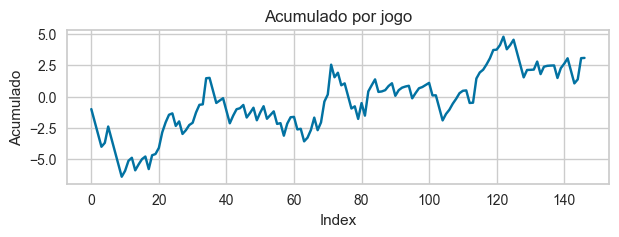




P(U)

---------------------  TREINO  ---------------------
PL: 3.81 | ROI: 2.13% | Prec.: 0.69
Odd média: 1.58 (0.63 WR)
Média Gain: 0.47 | Média Loss: -1.00
EM: 0.02
179 entradas em 2118 jogos (8.45%)


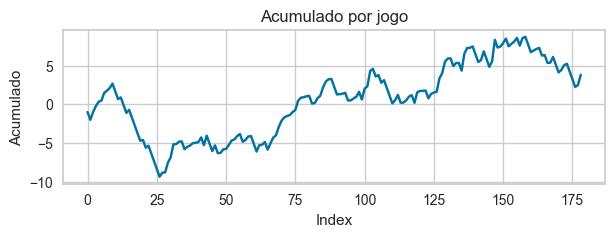

---------------------  TESTE  ---------------------
PL: 4.56 | ROI: 2.53% | Prec.: 0.69
Odd média: 1.57 (0.64 WR)
Média Gain: 0.48 | Média Loss: -1.00
EM: 0.02
180 entradas em 2119 jogos (8.49%)


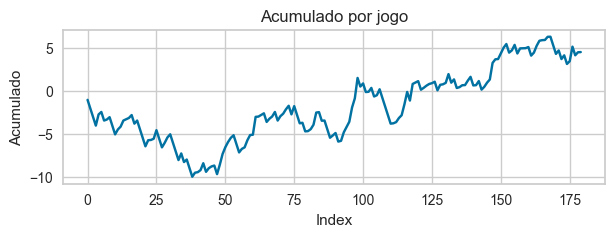




P_Diff

---------------------  TREINO  ---------------------
PL: 12.29 | ROI: 6.27% | Prec.: 0.72
Odd média: 1.57 (0.64 WR)
Média Gain: 0.48 | Média Loss: -1.00
EM: 0.06
196 entradas em 2118 jogos (9.25%)


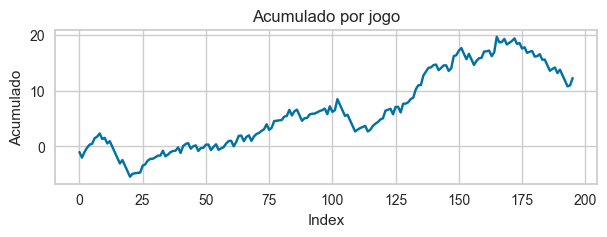

---------------------  TESTE  ---------------------
PL: 7.64 | ROI: 4.63% | Prec.: 0.70
Odd média: 1.58 (0.63 WR)
Média Gain: 0.49 | Média Loss: -1.00
EM: 0.04
165 entradas em 2119 jogos (7.79%)


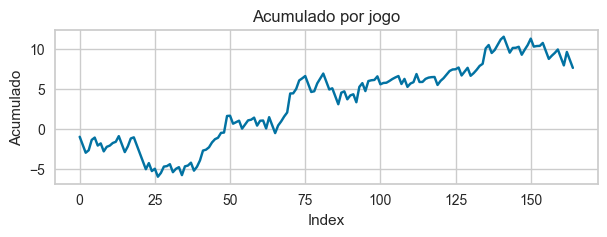




CV_ML

---------------------  TREINO  ---------------------
PL: 10.14 | ROI: 5.25% | Prec.: 0.66
Odd média: 1.67 (0.60 WR)
Média Gain: 0.60 | Média Loss: -1.00
EM: 0.06
193 entradas em 2118 jogos (9.11%)


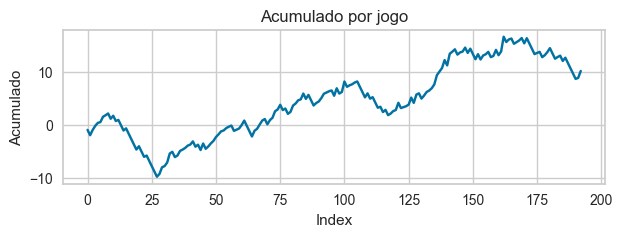

---------------------  TESTE  ---------------------
PL: 6.83 | ROI: 4.07% | Prec.: 0.66
Odd média: 1.66 (0.60 WR)
Média Gain: 0.58 | Média Loss: -1.00
EM: 0.04
168 entradas em 2119 jogos (7.93%)


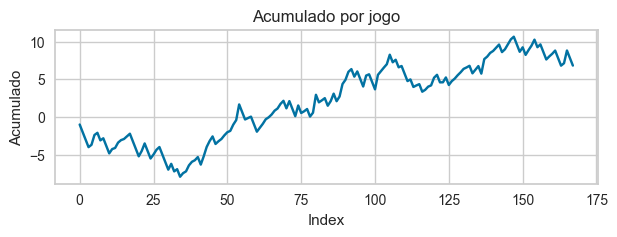




CV_Over

---------------------  TREINO  ---------------------
PL: 12.46 | ROI: 5.42% | Prec.: 0.71
Odd média: 1.57 (0.64 WR)
Média Gain: 0.48 | Média Loss: -1.00
EM: 0.05
230 entradas em 2118 jogos (10.86%)


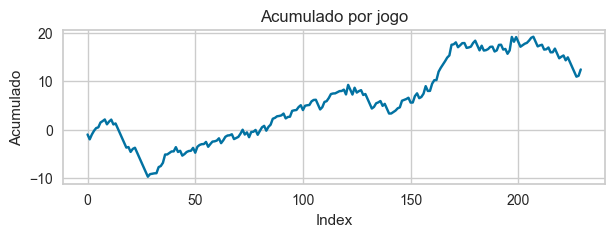

---------------------  TESTE  ---------------------
PL: 5.03 | ROI: 2.55% | Prec.: 0.71
Odd média: 1.53 (0.65 WR)
Média Gain: 0.45 | Média Loss: -1.00
EM: 0.03
197 entradas em 2119 jogos (9.30%)


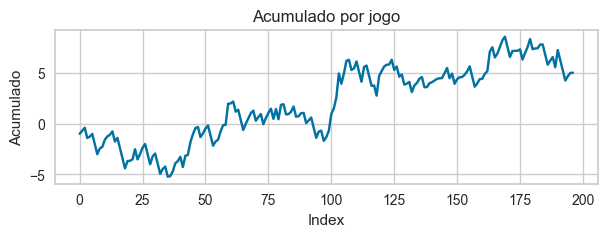




CV_HA

---------------------  TREINO  ---------------------
PL: -2.52 | ROI: -1.49% | Prec.: 0.67
Odd média: 1.57 (0.64 WR)
Média Gain: 0.46 | Média Loss: -1.00
EM: -0.02
169 entradas em 2118 jogos (7.98%)


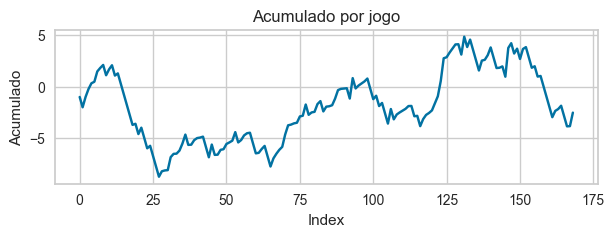

---------------------  TESTE  ---------------------
PL: 3.49 | ROI: 2.15% | Prec.: 0.69
Odd média: 1.59 (0.63 WR)
Média Gain: 0.49 | Média Loss: -1.00
EM: 0.03
162 entradas em 2119 jogos (7.65%)


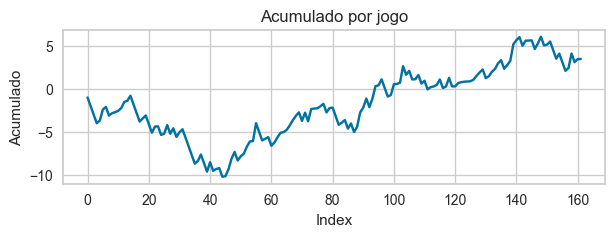




Last_CG_H

---------------------  TREINO  ---------------------
PL: 5.78 | ROI: 2.86% | Prec.: 0.73
Odd média: 1.52 (0.66 WR)
Média Gain: 0.41 | Média Loss: -1.00
EM: 0.03
202 entradas em 2118 jogos (9.54%)


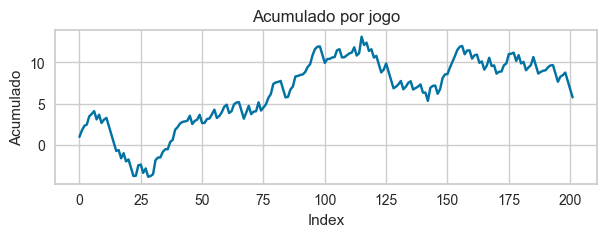

---------------------  TESTE  ---------------------
PL: 9.47 | ROI: 5.67% | Prec.: 0.72
Odd média: 1.54 (0.65 WR)
Média Gain: 0.47 | Média Loss: -1.00
EM: 0.06
167 entradas em 2119 jogos (7.88%)


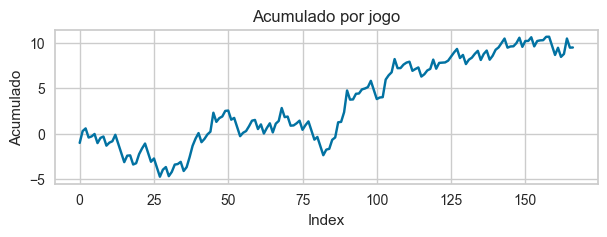




Last_CG_A

---------------------  TREINO  ---------------------
PL: 14.78 | ROI: 7.95% | Prec.: 0.73
Odd média: 1.59 (0.63 WR)
Média Gain: 0.48 | Média Loss: -1.00
EM: 0.08
186 entradas em 2118 jogos (8.78%)


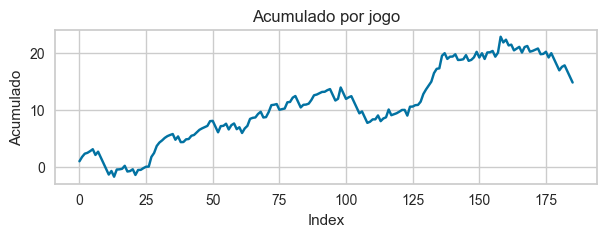

---------------------  TESTE  ---------------------
PL: 12.60 | ROI: 7.54% | Prec.: 0.72
Odd média: 1.57 (0.64 WR)
Média Gain: 0.50 | Média Loss: -1.00
EM: 0.08
167 entradas em 2119 jogos (7.88%)


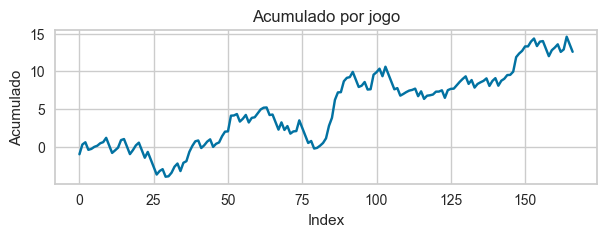




Odds_H

---------------------  TREINO  ---------------------
PL: 9.99 | ROI: 5.20% | Prec.: 0.66
Odd média: 1.67 (0.60 WR)
Média Gain: 0.60 | Média Loss: -1.00
EM: 0.06
192 entradas em 2118 jogos (9.07%)


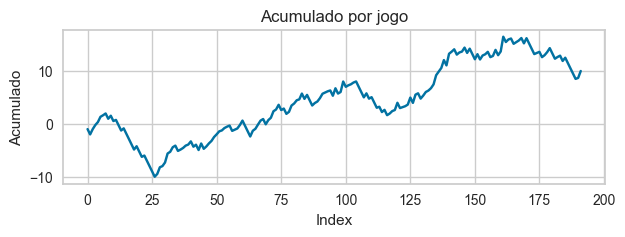

---------------------  TESTE  ---------------------
PL: 6.68 | ROI: 4.02% | Prec.: 0.66
Odd média: 1.67 (0.60 WR)
Média Gain: 0.58 | Média Loss: -1.00
EM: 0.05
166 entradas em 2119 jogos (7.83%)


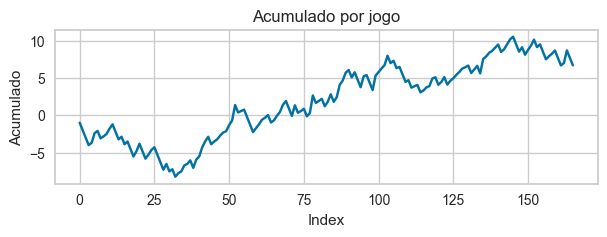

In [60]:
variaveis = features.copy()

ranges_dict = {}

for var in variaveis:
    try:
        # new_range = find_pos_range(var, treino = autocut_treino, teste = autocut_teste, validacao = autocut_val, ratio = 0.0, return_train=True, return_val=False)
        new_range = find_neg_range(var, treino = autocut_treino, teste = autocut_teste, validacao=autocut_val, return_train=True, return_val=False)
        # new_range = find_top_range(var, treino = autocut_treino, teste = autocut_teste, validacao = autocut_val, ratio = 3, return_train=False, return_val=False)
        ranges_dict[var] = new_range
    except:
        pass

# Comparação de modelos

### Escolhendo os modelos

In [ ]:
FILTRO = 1
CONJUNTO = 'teste_val'

for i in range(14):
    # try:
        if CONJUNTO == 'val':
            print(f'{top[i].__class__.__name__} (i = {i})\n')
            aux_total = treina_modelo(top[i], val1)
            aux_total = filtra_resultados(aux_total, filtro = FILTRO)
            plt.axvline(x=len(aux_total), color='red', linestyle='--')
            aux = info_modelo(top[i], pd.concat([val1, val2]), filtro = FILTRO)
        elif CONJUNTO == 'teste_val':
            print(f'{top[i].__class__.__name__} (i = {i})\n')
            aux_total = treina_modelo(top[i], real_teste)
            aux_total = filtra_resultados(aux_total, filtro = FILTRO)
            plt.axvline(x=len(aux_total), color='red', linestyle='--')
            aux = info_modelo(top[i], pd.concat([real_teste, val]), filtro = FILTRO)
        elif CONJUNTO == 'teste':
            print(f'{top[i].__class__.__name__} (i = {i})\n')
            aux = info_modelo(top[i], real_teste, filtro = FILTRO)
    # except:
    #     print(f'O modelo apresentou um erro.\n')
    #     pass

In [ ]:
blended710 = blend_models(estimator_list = [top[10], top[7]], fold = 5, verbose=False)

In [ ]:
model_list = [top[7], top[10], blended710]

### Resultados

In [ ]:
FILTRO = 1

for item in model_list:
    try:
        print(f'{item.__class__.__name__}\n')
        aux_total = treina_modelo(item, real_teste)
        aux_total = filtra_resultados(aux_total, filtro = FILTRO)
        plt.axvline(x=len(aux_total), color='red', linestyle='--')
        aux = info_modelo(item, pd.concat([real_teste, val]), filtro = FILTRO)
    except:
        print(f'O modelo apresentou um erro.\n')
        pass

# Script qcut

In [ ]:
# df_cut1 = df_treino.copy()
df_cut = df_comp.copy()
# df_cut = pd.concat([df_cut1, df_cut2])

In [ ]:
variaveis = features.copy()
variaveis.append('prediction_score')

for var in variaveis:
    try:
        nome = f'Cat_{var}'
        # Usa qcut para definir os grupos
        df_cut[nome]  = pd.qcut(df_cut[var], q = 7, duplicates='drop')

        target = 'PL_BF_Predictions'
        pivot_table = pd.pivot_table(df_cut,
                                    values=target,
                                    index=[nome],
                                    aggfunc=['sum', 'count']
                                    )
        

        pivot_table['ratio'] = pivot_table[('sum', target)] / pivot_table[('count', target)]

        aux_treino = pivot_table[pivot_table['ratio'] != 0]


        print(var)
        print(aux_treino)
        print()
        print('\n\n')
        print('------------------------------------------------')
        print('\n\n')
    except:
        pass

In [ ]:
_df = _df[((_df['CV_ML'] >= 0) & (_df['CV_ML'] < 0.65)) | ((_df['CV_ML'] >= 0.77) & (_df['CV_ML'] < 0.87)) | ((_df['CV_ML'] >= 0.95) & (_df['CV_ML'] < 1.5))]

_df = _df[((_df['P_Diff'] < 0.42) | (_df['P_Diff'] > 0.44))]


In [ ]:
# display(df_cut2.groupby('Cat_DP_Odds_Geral_H')['DP_Odds_Geral_H'].describe())

# Script variáveis

In [ ]:
colunas = ['Odds_H', 'Odds_A', 'Over_Line', 'Odds_Over', 'Odds_Under', 'HA_Line',
       'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 'P(O)', 'P(U)', 'P_Diff', 'Porc_Over_Home',
       'Porc_Over_Away', 'Avg_CG_H', 'DP_CG_H',
       'CV_CG_H', 'Avg_CG_A', 'DP_CG_A', 'CV_CG_A', 'MediaCustoGolHome',
       'MediaCustoGolAway', 'Last_CG_H', 'Last_CG_A', 'Acima_Last_CG_H',
       'Acima_Last_CG_A', 'Abaixo_Last_CG_H', 'Abaixo_Last_CG_A', 'CV_ML',
       'CV_Over', 'CV_HA', 'Retornos_BH_Acu', 'Avg_Retornos_BH', 'Custo_Retorno_BH',
       'Avg_Porc_BH_Bookie', 'Avg_Porc_BH_Real', 'Dist_Porc_BH',
       'Retornos_BA_Acu', 'Avg_Retornos_BA', 'Custo_Retorno_BA',
       'Avg_Porc_BA_Bookie', 'Avg_Porc_BA_Real', 'Dist_Porc_BA']

colunas = ['Odds_H', 'Odds_A', 'Odds_Over', 'Odds_Under', 'Over_Line',  'HA_Line', 'HA_Odds_H', 'HA_Odds_A', 'P(H)', 'P(A)', 
       'P(O)', 'P(U)', 'P_Diff', 'CV_ML',
       'CV_Over', 'CV_HA']

In [ ]:
import random

def pegar_elementos_aleatorios(lista):
    # Gerar um número aleatório entre 2 e 7
    num_elementos = random.randint(5, 12)

    # Garantir que o número de elementos não ultrapasse o tamanho da lista
    num_elementos = min(num_elementos, len(lista))

    # Selecionar elementos aleatórios da lista
    elementos_aleatorios = random.sample(lista, num_elementos)

    return elementos_aleatorios

In [ ]:
def cria_modelo(fts, _seed = 2023, _filtro = 0):
        try:
                cria_setup(features=fts, seed = _seed)

                model = create_model('nb', verbose = False, fold = 5)
                tab = pull()
                prec_model = (tab.loc['Mean', 'Prec.'])
                previsoes = predict_model(model, verbose = False)

                stake = 1

                total = previsoes.shape[0]

                previsoes = previsoes[previsoes['prediction_label'] == 1]
                previsoes = filtra_resultados(previsoes, filtro = _filtro)

                previsoes.loc[(previsoes[TARGET] == 1), 'PL_BF_Predictions'] = (previsoes[ODDS] - 1) * stake
                previsoes.loc[(previsoes[TARGET] == 0), 'PL_BF_Predictions'] = - stake

                plb = previsoes['PL_BF_Predictions'].sum()
                entradas = previsoes.shape[0]
                wr = round((previsoes[previsoes[TARGET] == 1].shape[0] / entradas), 2)
                oddback = previsoes[previsoes['prediction_label'] == 1][ODDS].mean()
                med_gain = previsoes[previsoes[TARGET] == 1]['PL_BF_Predictions'].mean()
                med_loss = previsoes[previsoes[TARGET] == 0]['PL_BF_Predictions'].mean()
                roi = plb / entradas
                porc_ent = entradas / total
                ev = (wr*stake*med_gain) + ((1-wr)*med_loss*stake)

                metrics = [prec_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev]

                return metrics
        except Exception as e:
                print(e)
                return [0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
melhor_PL = -10000

for i in range(20):
    feats = pegar_elementos_aleatorios(colunas)
    feats.append(ODDS)

    metrics = cria_modelo(fts=feats)
    prec_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics
            
    print(f'Rodada {i+1}')
    if plb > melhor_PL:
        melhor_PL = plb
        print(f'**Novo melhor**')
        print(f'Precision: {prec_model:.4f}')
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
        print(f'features = {feats}\n')
    print()

# Segundo filtro

In [ ]:
fits = ['Odds_A', 'CV_ML', 'P(U)', 'P(O)', 'Odds_Over', 'P_Diff', 'HA_Odds_A', 'HA_Line', 'Odds_Under', 'Odds_Over']

fits = ['Odds_A', 'CV_ML', 'P(U)', 'P(O)', 'P_Diff', 'HA_Odds_A', 'HA_Line', 'Odds_Under', 'Odds_Over']


In [ ]:
metrics = cria_modelo(fits)
prec_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics

print('---------------------- BASE ----------------------')
print(f'Precision: {prec_model:.4f}')
print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
print(f'fits = {fits}\n')
print('--------------------------------------------------')
melhor_PL = plb

for i in range(len(fits) - 1):
    feat = fits[i]
    fits.pop(i)
    print(f'Removido: {feat}')

    metrics = cria_modelo(fits)
    prec_model, plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics

    if plb >= melhor_PL:
        print('*** NOVO MELHOR ***')
        melhor_PL = plb
    print(f'Precision: {prec_model:.4f}')
    print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
    print(f'fits = {fits}\n')
    fits.insert(i, feat)
    print()

# Cross validation

In [ ]:
results = []
seeds = random.sample(range(0, 9999), 10)

for i in range(len(seeds)):

        cria_setup(seed=seeds[i], features=features)

        cross_model = create_model('nb', verbose = False, cross_validation=False)
        
        previsoes = predict_model(cross_model, val, verbose = False)
        previsoes = previsoes.merge(df[ODDS], left_index=True, right_index=True, how='left')
        if f'{ODDS}_x' in previsoes.columns.tolist():
                previsoes.rename(columns={f'{ODDS}_x': ODDS}, inplace=True)
                previsoes.drop(columns=f'{ODDS}_y', inplace=True)

        stake = 1

        total = previsoes.shape[0]

        previsoes = previsoes[(previsoes['prediction_label'] == 1)]

        previsoes.loc[(previsoes[TARGET] == 1), 'PL_BF_Predictions'] = (previsoes[ODDS] - 1) * stake
        previsoes.loc[(previsoes[TARGET] == 0), 'PL_BF_Predictions'] = - stake

        ############ Filtro ############
        previsoes = filtra_resultados(previsoes, filtro = 1)
        previsoes = calcula_profit(previsoes)
        metrics = exibe_metricas(previsoes, total = total, return_metrics=True)
        plb, wr, oddback, med_gain, med_loss, roi, porc_ent, ev = metrics
        
        results.append(wr)

        print(f'Fold {i+1} (seed {seeds[i]})')
        print(f'PL: {plb:.2f} | ROI: {100*roi:.2f}% | EM: {ev:.2f} | Prec.: {wr:.2f} | Entradas: {porc_ent:.2f}')
        exibe_grafico(previsoes, per_day=True)
        print()

print(f'Média: {np.mean(results):.2f} | DP: {np.std(results):.2f}')

In [ ]:
775
5307
8909

# Entradas Aleatórias

In [ ]:
def new_random_model(_val, _n):

    for i in range(_n):
        random_df = _val.copy()
        random_df['Entrada'] = [random.choice([0, 1]) for _ in range(len(random_df))]

        random_df = random_df[random_df['Entrada'] == 1]
        random_df.loc[(random_df[TARGET] == 1), 'PL'] = (random_df[ODDS] - 1)
        random_df.loc[(random_df[TARGET] == 0), 'PL'] = - 1
        
        random_df.sort_values('Date', inplace=True)
        random_df.reset_index(drop=True, inplace=True)
        random_df['hbacu'] = random_df['PL'].cumsum()
        random_df['hbacu'].plot.line(figsize=(12,6))
    
    plt.show()

In [ ]:
new_random_model(val, 10)